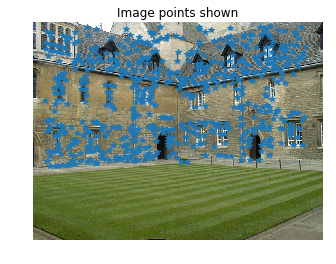

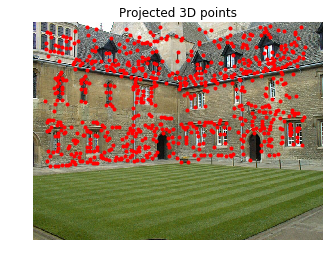

In [18]:
#Multiple View Geometry
import camera
import sfm
from numpy import *
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import *
# load some images
im1 = np.array(Image.open('Images/001.jpg'))
im2 = np.array(Image.open('Images/002.jpg'))
# load 2D points for each view to a list
points2D = [loadtxt('2D/00'+str(i+1)+'.corners').T for i in range(3)]
# load 3D points
points3D = loadtxt('3D/p3d').T
# load correspondences
corr = genfromtxt('2D/nview-corners',dtype='int',missing_values='*')
# load cameras to a list of Camera objects
P = [camera.Camera(loadtxt('2D/00'+str(i+1)+'.P')) for i in range(3)]
# make 3D points homogeneous and project
X = vstack( (points3D,ones(points3D.shape[1])) )
x = P[0].project(X)
# plotting the points in view 1
plt.figure()
plt.imshow(im1)
plt.plot(points2D[0][0],points2D[0][1],'*')
plt.title("Image points shown")
plt.axis('off')
#plotting 3D
plt.figure()
plt.imshow(im1)
plt.plot(x[0],x[1],'r.')
plt.axis('off')
plt.title("Projected 3D points")
plt.show()

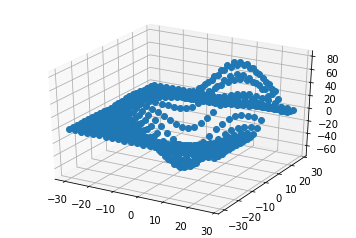

In [27]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection="3d")
# generate 3D sample data
X,Y,Z = axes3d.get_test_data(0.25)
# plot the points in 3D
ax.plot(X.flatten(),Y.flatten(),Z.flatten(),'o')
plt.axis()
plt.show()

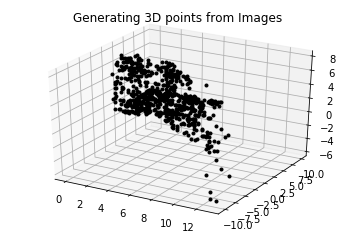

In [28]:
# plotting 3D points
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(points3D[0],points3D[1],points3D[2],'k.')
plt.title("Generating 3D points from Images")
plt.axis()
plt.show()

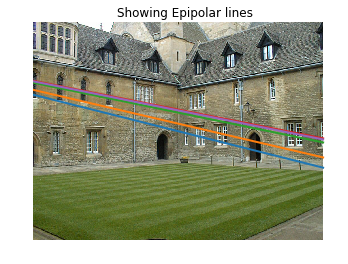

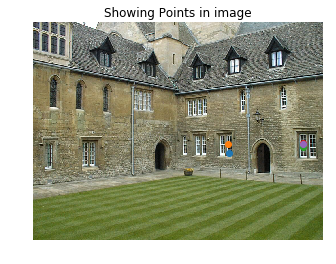

In [35]:
def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
(x1,x2 3*n arrays) using the normalized 8 point algorithm.
each row is constructed as
[x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don’t match.")
    # build matrix for equations
    A = zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
            x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
            x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
        
        
    # compute linear least square solution
    U,S,V = linalg.svd(A)
    F = V[-1].reshape(3,3)
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = linalg.svd(F)
    S[2] = 0
    F = dot(U,dot(diag(S),V))
    return F
def compute_epipole(F):
    """ Computes the (right) epipole from a
fundamental matrix F.
(Use with F.T for left epipole.) """
    # return null space of F (Fx=0)
    U,S,V = linalg.svd(F)
    e = V[-1]
    return e/e[2]
# index for points in first two views
ndx = (corr[:,0]>=0) & (corr[:,1]>=0)
# get coordinates and make homogeneous
x1 = points2D[0][:,corr[ndx,0]]
x1 = vstack( (x1,ones(x1.shape[1])) )
x2 = points2D[1][:,corr[ndx,1]]
x2 = vstack( (x2,ones(x2.shape[1])) )
# compute F
F = sfm.compute_fundamental(x1,x2)
# compute the epipole
e = sfm.compute_epipole(F)
# plotting
plt.figure()
plt.imshow(im1)
# plot each line individually, this gives nice colors
for i in range(5):
    sfm.plot_epipolar_line(im1,F,x2[:,i],e,False)
plt.axis('off')
plt.title("Showing Epipolar lines")
plt.figure()
plt.imshow(im2)
# plot each point individually, this gives same colors as the lines
for i in range(5):
    plt.plot(x2[0,i],x2[1,i],'o')
plt.axis('off')
plt.title("Showing Points in image")
plt.show()